# Image formation

- Given
    - World Coornidate 3D Points
    - Camera Intrinsic Parameter
    - Camera Orientation and Position
- Unknown
    - Image Plane 2D Points


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import csv
%matplotlib inline

Rotation Matrix
$
R_x(\theta) =
\begin{bmatrix}
1 & 0 & 0 \\
0 & cos(\theta) & -sin(\theta) \\
 0 & sin(\theta) & cos(\theta)
\end{bmatrix}
$

$
R_y(\theta) =
\begin{bmatrix}
cos(\theta) & 0 & sin(\theta) \\
0 & 1 & 0 \\
-sin(\theta) & 0 & cos(\theta)
\end{bmatrix}
$

$
R_z(\theta) =
\begin{bmatrix}
cos(\theta) & -sin(\theta) & 0 \\
sin(\theta) & cos(\theta) & 0 \\
0 & 0 & 1
\end{bmatrix}
$

In [ ]:
def RX(rx):
    return np.array([[1., 0, 0],
                     [0, math.cos(rx), -math.sin(rx)],
                     [0, math.sin(rx), math.cos(rx)]], dtype=np.float32)

def RY(ry):
    return np.array([[math.cos(ry), 0, math.sin(ry)],
                     [0, 1, 0],
                     [-math.sin(ry), 0, math.cos(ry)]], dtype=np.float32)

def RZ(rz):
    return np.array([[math.cos(rz), -math.sin(rz), 0],
                     [math.sin(rz), math.cos(rz), 0],
                     [0, 0, 1]], dtype=np.float32)

In [ ]:
# read xyz file
# format Homogenous Coordinate
X = np.loadtxt("box.xyz")
X = np.hstack((X, np.ones((X.shape[0], 1)))).T
X.shape

(4, 160)

In [ ]:
X.min(axis=1), X.max(axis=1)

(array([-1. , -0.5,  5. ,  1. ]), array([1. , 0.5, 6. , 1. ]))

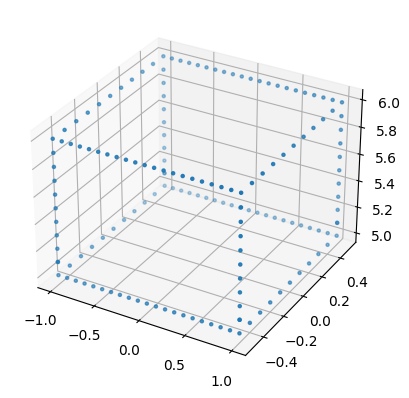

In [ ]:
def plot_data(ax, x, y, z):
  ax.scatter(x, y, z, marker='.')

fig = plt.figure()
ax = plt.axes(projection='3d')
plot_data(ax, X[0], X[1], X[2])
plt.show()


### Camera Intrinsic Parameter

$
f = 1000, cx = 320, cy = 240 \\
K = \begin{bmatrix} f & 0 & cx \\ 0 & f & cy \\ 0 & 0 & 1 \end{bmatrix}
$

Camera Orientation and Position
Projection Matrix P
$
\begin{aligned}
R_c &= R_z(\theta_z) R_y(\theta_y) R_x(\theta_x) \\
t_c &= \begin{bmatrix} t_x \\ t_y \\ t_z \end{bmatrix} \\
\\
R &= R_c^T \\
t &= -R_c^T t_c \\
P &= K [R|t] \\
\end{aligned}
$

In [ ]:
# image resolution
img_res = np.array([480, 640])
w, h = img_res[1], img_res[0]

# Camera Intrinsic Parameter
f, cx, cy = 1000, 320, 240

# Pixel size ranges from 1.1 microns in the smallest smartphone sensor, to 8.4 microns in a Full-Frame sensor.
px_size = 0.001

# Camera Orientation and Position
cam_ori = np.array([[0, 0, 0], [-np.pi/12 , np.pi/12, 0], [np.pi/12, -np.pi/12, 0], [np.pi/12, np.pi/12, 0], [-np.pi/12, -np.pi/12, 0]])
cam_pose = np.array([[0, 0, 0], [-2, -2, 0], [2, 2, 0], [-2, 2, 0], [2, -2 ,0]])
# set noise std
noise_std = 1

cam_ori, cam_pose

(array([[ 0.        ,  0.        ,  0.        ],
        [-0.26179939,  0.26179939,  0.        ],
        [ 0.26179939, -0.26179939,  0.        ],
        [ 0.26179939,  0.26179939,  0.        ],
        [-0.26179939, -0.26179939,  0.        ]]),
 array([[ 0,  0,  0],
        [-2, -2,  0],
        [ 2,  2,  0],
        [-2,  2,  0],
        [ 2, -2,  0]]))

In [ ]:
# Derive the extrinsice Matrix
def extrinsic_mat(ori, pose):
  Rc = RZ(ori[2]) @ RY(ori[1]) @ RX(ori[0])
  tc = pose
  R = Rc.T
  t = -Rc.T @ tc
  return R, t

In [ ]:
def plot_camera(ax, R, t, w, h, f, scale=0.0001):
  V = np.array([[0, 0, 0, f, -w/2,  w/2, w/2, -w/2],
                [0, 0, f, 0, -h/2, -h/2, h/2,  h/2],
                [0, f, 0, 0,  f,    f,   f,    f]])
  V *= scale # px size
  V = R.T @ (V - t.reshape((3, 1)))

  ax.plot(V[0, [0, 3]], V[1, [0, 3]], zs=V[2, [0, 3]], color='r') # x-axis
  ax.plot(V[0, [0, 2]], V[1, [0, 2]], zs=V[2, [0, 2]], color='g') # y-axis
  ax.plot(V[0, [0, 1]], V[1, [0, 1]], zs=V[2, [0, 1]], color='b') # z-axis

  ax.plot(V[0, [0, 4]], V[1, [0, 4]], V[2, [0, 4]], color='k')
  ax.plot(V[0, [0, 5]], V[1, [0, 5]], V[2, [0, 5]], color='k')
  ax.plot(V[0, [0, 6]], V[1, [0, 6]], V[2, [0, 6]], color='k')
  ax.plot(V[0, [0, 7]], V[1, [0, 7]], V[2, [0, 7]], color='k')

  ax.plot(V[0, [4,5,6,7,4]], V[1, [4,5,6,7,4]], V[2, [4,5,6,7,4]], color='k')

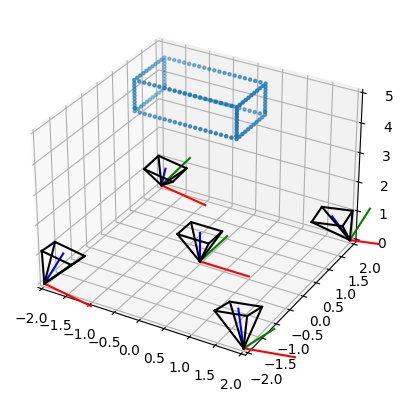

In [105]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(0, 5)
for ori, pose in zip(cam_ori, cam_pose):
  R, t = extrinsic_mat(ori, pose)
  plot_camera(ax, R, t, w, h, f, px_size)
plot_data(ax, X[0], X[1], X[2])
plt.show()

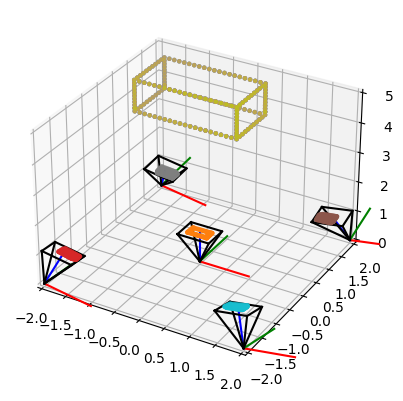

In [111]:
# Generate images for each camera pose
K = np.array([[f, 0, cx],
              [0, f, cy],
              [0, 0, 1]])
intrinsic_mat = np.array([[f*px_size, 0,         0],
                           [0,         f*px_size, 0],
                           [0,         0,         1]])
images = []
fig = plt.figure()
ax = plt.axes(projection='3d')
for i, (ori, pose) in enumerate(zip(cam_ori, cam_pose)):
    R, t = extrinsic_mat(ori, pose)
    Rt = np.hstack((R, t.reshape(3, 1))) # 3x4

    # Transform points to camera CS.
    X_cam = Rt@X # (3,4)x(4,N)=(3,N)

    # Project points in camera CS (non-linear, divided by Z).
    X_img = intrinsic_mat@X_cam # (3,3)x(3,N)=(3,N)
    X_img /= X_img[2]
    X_img[2] *= f*px_size
    X_img_wc = R.T@X_img-R.T@t.reshape(3,1) # Convert from camera to global CS since we plot in global CS

    # Plot image formation in 3D.
    plot_camera(ax, R, t, w, h, f, px_size)
    plot_data(ax, X[0], X[1], X[2])
    plot_data(ax, X_img_wc[0], X_img_wc[1], X_img_wc[2])
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(0, 5)

    # Project the points to image plane
    P = K @ Rt
    x = P @ X # 3xN
    x /= x[2] # 3xN (u, v, 1)

    # Add Gaussian Noise
    noise = np.random.normal(0, noise_std, size=(x.shape))
    x += noise

    # Show and store the points
    image = np.zeros(img_res)
    for p in x.T:
        if p[0] >= 0 and p[0] < image.shape[1] and p[1] >= 0 and p[1] < image.shape[0]:
            image = cv2.circle(image, (int(p[0]), int(p[1])), 2, 255, -1)
    images.append(image)
plt.show()

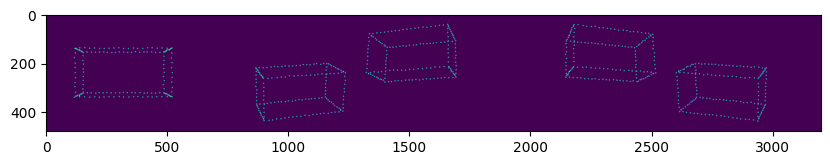

In [ ]:
images = np.hstack(images)
plt.figure(figsize=(10, 20))
plt.imshow(images)